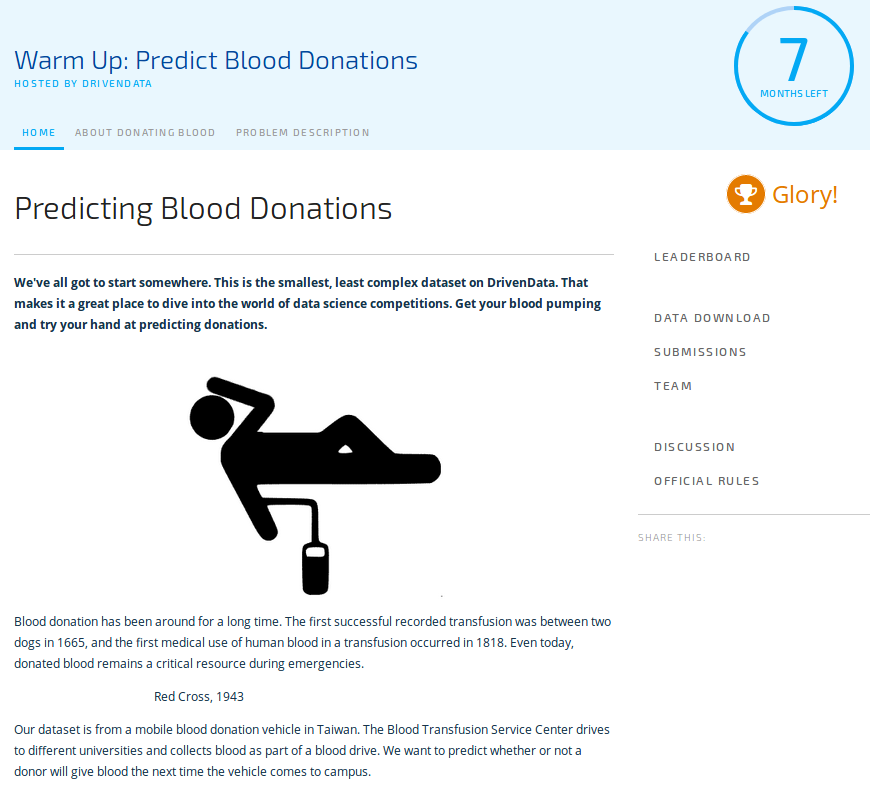

In [2]:
#!/usr/bin/env python3
#-*- coding: utf8 -*-



########################################################################################################
########################################################################################################

# DRIVEN DATA - PREDICT BLOOD DONATIONS

########################################################################################################
########################################################################################################


from IPython.display import Image
Image("../intro.png")

In [3]:
########################################################################################################
########################################################################################################

# 00-first_dataset_tour.py

########################################################################################################
########################################################################################################


# Find here a first study of the dataset, in which we seek to understand and
# give meaning to the dataset.

# We are not trying to solve our problem but will focus on visualization,
# clenaning and feature engineering.

# At first we will just study the corelations, the links, the quality and the
# meaning of our dataset.External research and more general considerations may be included in this work


In [4]:
# import

import os, sys, logging, random, time

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


In [5]:
# logging and warnings

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# l = logging.WARNING
# logging.basicConfig(level=l, format="%(levelname)s : %(message)s")

info = logging.info

import warnings
warnings.filterwarnings('ignore')


In [6]:
# graph

%matplotlib inline
sns.set()


In [7]:
# consts

PROJECT     = "Driven-Data-Blood-Donations"
DATA        = "data"
SUBMISSIONS = "submissions"
TRAIN_FILE  = "training_data.csv"
TEST_FILE   = "test_data.csv"


In [8]:
# 'overkill' First we define two decorators. it will be useful to control 
# complex and long algo (grid search, finding meta params...) :

def caller(funct) : 
    """decorator to give call and end of a function"""

    def wrapper(*args, **kwargs) : 

        msg = funct.__name__ + " : called"
        print(msg)
        

        res = funct(*args, **kwargs)

        msg = funct.__name__ + " : ended"
        print(msg)

        return res

    return wrapper


def timer(funct) : 
    """decorator to give runing time of a function"""

    def wrapper(*args, **kwargs) : 
        
        t = time.time()

        res = funct(*args, **kwargs)

        t = round(time.time() - t, 2)
        msg = funct.__name__ + " : " + str(t) + " secs" 
        print(msg)

        return res

    return wrapper


####


@caller
@timer
def _print() : 
    print("this is a test")
    
_print()

wrapper : called
this is a test
_print : 0.0 secs
wrapper : ended


In [9]:
# Our first function : just find the data folder in the repo 
# structure from anywhere

def finding_master_path(folder, project=PROJECT) :
    """just find our data folder in the repo structure from
    anywhere"""

    path = os.getcwd()
    path = path.split("/")

    idx  = path.index(project)
    path = path[:idx+1]
    folder = str(folder) + "/"
    path.append(folder)
    
    path = "/".join(path)

    # check if path is a valid path
    if os.path.isdir(path) : 
        return path
    
    li = [i for i in os.listdir() if (os.path.isdir(i) and (i[0]!="."))]
    if project in li : 
        path = os.getcwd + "/" + project
        return path

    return ValueError("project not found, please 'cd project")


####


path = finding_master_path(DATA)
path


'/home/alex/Driven-Data-Blood-Donations/data/'

In [10]:
# Control that our datafiles are Ok

def return_datasets(path) : 

    return [i for i in os.listdir(path) if ".csv" in i ]


####


datasets = return_datasets(path)
datasets


['submission_format.csv', 'test_data.csv', 'training_data.csv']

In [11]:
# Init our dataframe 

def init_df(path, file) : 

    df = pd.read_csv(path+file, index_col=0)

    if len(df.columns)  == 5 : 
        df.columns  = pd.Index( ["last_don", "num_don","vol_don", "first_don", 
                            "target"], dtype="object")
    elif len(df.columns )  == 4 : 
        df.columns  = pd.Index( ["last_don", "num_don","vol_don", "first_don", 
                            ], dtype="object")
    else : 
        raise ValueError("invalid numb of columns")

    return df


####


df = init_df(path, TRAIN_FILE)
df.head()


,last_don,num_don,vol_don,first_don,target
619,2,50,12500,98,1
664,0,13,3250,28,1
441,1,16,4000,35,1
160,2,20,5000,45,1
358,1,24,6000,77,0


In [12]:
# Let's have a first raw tour about this df

def print_df(df) : 

    print("data frame dimension :       ")
    print(df.ndim)

    print("\n\ndata frame shape :       ")
    print(df.shape)

    print("\n\ndata frame types :      ")
    print(df.dtypes)

    print("\n\ndata frame index :       ") 
    print(df.index)

    print("\n\ndata frame columns :     ")
    print(df.columns)

    print("\n\ndata frame head :        ")
    print(df.head(3))

    print("\n\ndata frame tail :        ")
    print(df.tail(3))

    print("\n\ndata frame desc :        ")
    print(df.describe())

    
####


print_df(df)


data frame dimension :       
2


data frame shape :       
(576, 5)


data frame types :      
last_don     int64
num_don      int64
vol_don      int64
first_don    int64
target       int64
dtype: object


data frame index :       
Int64Index([619, 664, 441, 160, 358, 335,  47, 164, 736, 436,
            ...
            361,  30, 337, 496, 169, 698, 433, 360, 541,  74],
           dtype='int64', length=576)


data frame columns :     
Index(['last_don', 'num_don', 'vol_don', 'first_don', 'target'], dtype='object')


data frame head :        
     last_don  num_don  vol_don  first_don  target
619         2       50    12500         98       1
664         0       13     3250         28       1
441         1       16     4000         35       1


data frame tail :        
     last_don  num_don  vol_don  first_don  target
360        21        2      500         52       0
541        39        1      250         39       0
74         72        1      250         72       0


data frame de

In [13]:
# 'overkill' Let's retype our values to reduce mem usage 

def re_dtype(df) : 

    # li = [np.uint8, np.uint16]
    # [print(i,  np.iinfo(i).min, np.iinfo(i).max) for i in li]

    if len(df.columns) == 5 : 
        dtypes_dict = { "last_don"  : np.uint8, 
                        "num_don"   : np.uint8,
                        "vol_don"   : np.uint16, 
                        "first_don" : np.uint8, 
                        "target"    : np.uint8       }

        return df.astype(dtypes_dict)

    elif len(df.columns) == 4 : 
        dtypes_dict = { "last_don"  : np.uint8, 
                        "num_don"   : np.uint8,
                        "vol_don"   : np.uint16, 
                        "first_don" : np.uint8,      }

        return df.astype(dtypes_dict) 

    raise ValueError("pb occured")
    

####


df = re_dtype(df)
df.head()
df.dtypes


last_don      uint8
num_don       uint8
vol_don      uint16
first_don     uint8
target        uint8
dtype: object

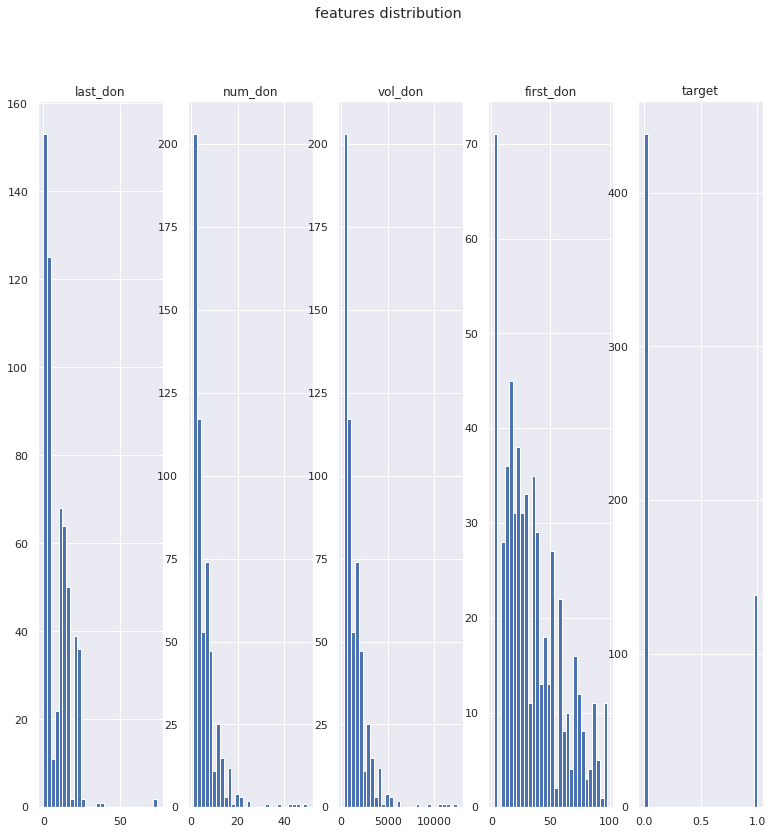

In [14]:
# Let's have a second tour of our dataset but with graphical tools

def graph_each_feature(df)  : 

    # features = [i for i in df.columns if "target" not in i] 

    features = df.columns

    fig, _axes = plt.subplots(1, 5, figsize=(13,13))
    axes = _axes.flatten()

    info(fig)
    info(axes)
    info(len(axes))

    for i, feat in enumerate(features) :
        info(i, feat)

        # -----------------------------------------
        # use sns.pairplot() !!!!!!
        # sns.distplot --> (kde=True ) ???
        # -----------------------------------------

        axes[i].hist(df[feat], bins=30)
        axes[i].set_title(feat)

    plt.suptitle("features distribution")
    plt.show()
    
    
####


graph_each_feature(df)


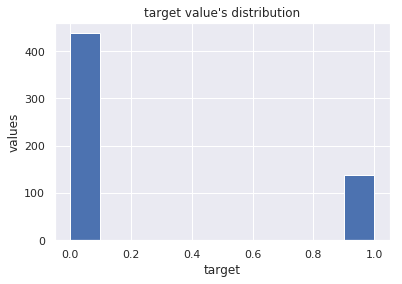

In [15]:
# Idem for target

def graph_target(df) : 

    df.target.hist()
    plt.xlabel("target")
    plt.ylabel("values")
    plt.title("target value's distribution")
    plt.show()
    
    
####


graph_target(df)


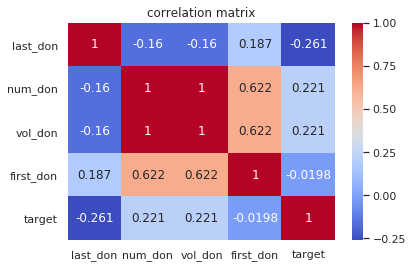

In [16]:
# Looking in depth : finding correlation between features

def graph_corr_matrix(df) : 
    
    corr_mat = df.corr()
    sns.heatmap(corr_mat, cmap="coolwarm", annot=True, fmt='.3g')

    plt.title("correlation matrix")
    plt.show()

    
####


graph_corr_matrix(df)


In [17]:
# So without doupt we can drop perfectly correlated features

def drop_corr_features(df) : 

    df = df.drop("vol_don", axis=1)

    return df 


####


df = drop_corr_features(df)
df.head()


,last_don,num_don,first_don,target
619,2,50,98,1
664,0,13,28,1
441,1,16,35,1
160,2,20,45,1
358,1,24,77,0


In [18]:
# What about nas?

def study_nas(df) : 

    print("nas all : ")
    print(df.isna().all())
    print("\n\nnas any : ")
    print(df.isna().any())
    
    
####


study_nas(df)


nas all : 
last_don     False
num_don      False
first_don    False
target       False
dtype: bool


nas any : 
last_don     False
num_don      False
first_don    False
target       False
dtype: bool


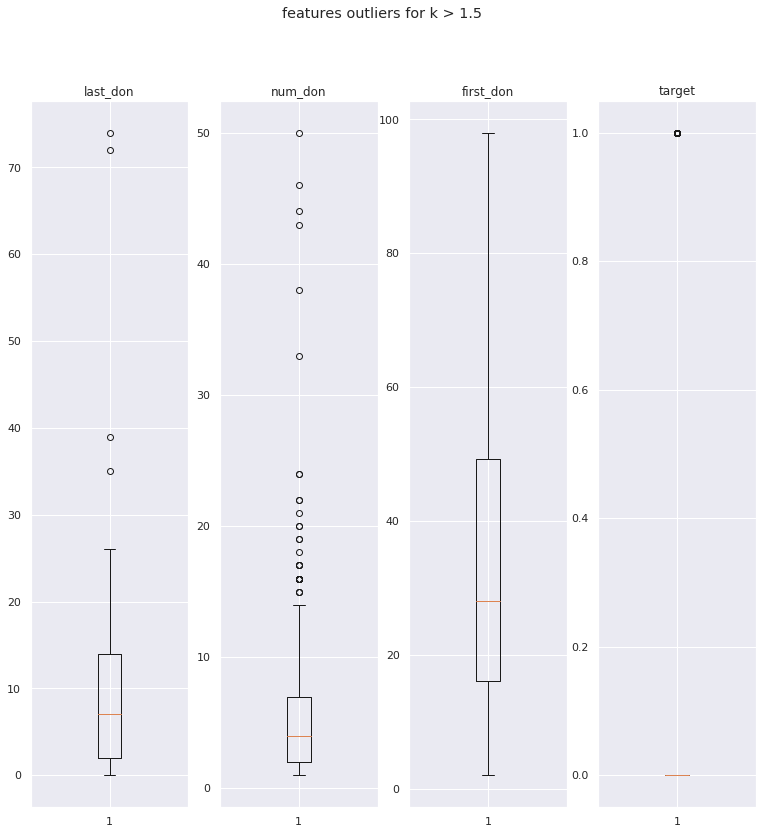

In [19]:
# Ok perfect, too easy maybe...
# what about outliers ? 

def study_outliers(df, k=1.5) : 

    fig, _axes = plt.subplots(1, 4, figsize=(13,13))
    axes = _axes.flatten()

    info(fig)
    info(axes)
    info(len(axes))

    for i, feat in enumerate(df.columns) :
        info(i, feat)
        axes[i].boxplot(df[feat], whis=k)
        axes[i].set_title(feat)

    plt.suptitle("features outliers for k > {}".format(k))
    
    plt.show()

    
####


study_outliers(df)


In [20]:
# After all ! we have a first real data scientist job to do : cleaning! 
# so we will design one function to be able to reshape our df at will

def return_outliers(ser, k) : 

    desc = ser.describe()
    q1, q3, q2 = desc["25%"], desc["75%"], desc["50%"]
    IQ = q3-q1
    range_min, range_max = q1 - k * IQ, q3 + k*IQ

    # outliers = ser[(ser > range_max) or (ser < range_min)]
    
    return ser >= range_max


def delete_outliers(df, k) : 

    li = [i for i in df.columns if "target" not in i]

    for feat in li : 
        df = df[return_outliers(df[feat], k) == False]

    return df


####


print(df.shape)

_df = delete_outliers(df, 1.5)
print(_df.shape)


(576, 4)
(537, 4)


In [21]:
# Let's resume all of this in a global function

# @caller
# @timer
def first_tour(folder=None, filename=None, project=PROJECT) : 

    # build data path
    path = finding_master_path(folder, project)
    print(path)                             # UNCOMMENT IF NEEDED

    # just show dataset list
    datasets = return_datasets(path)        # UNCOMMENT IF NEEDED
    print(datasets)                         # UNCOMMENT IF NEEDED

    # build our df
    df = init_df(path, filename)

    # print main info
    print_df(df)                            # UNCOMMENT IF NEEDED

    # (overkilled) recast dataframe in a better dtype
    df = re_dtype(df)

    # graph features distr and correlation  # UNCOMMENT IF NEEDED
    graph_each_feature(df)                  
    graph_corr_matrix(df)                   # UNCOMMENT IF NEEDED

    # drop corr values
    df = drop_corr_features(df)

    # nas
    study_nas(df)                           # UNCOMMENT IF NEEDED

    for i in [1.5, 2, 2.5, 3] :             # UNCOMMENT IF NEEDED
        study_outliers(df, i)               # UNCOMMENT IF NEEDED


In [22]:
# Finally we define a function to auto build our data frame

@caller
@timer
def build_df(folder=None, filename=None, project=PROJECT) : 

    path = finding_master_path(folder, project)
    df = init_df(path, filename)
    df = re_dtype(df)
    df = drop_corr_features(df)

    return df


####


df = build_df(DATA, TRAIN_FILE)
df.head()


wrapper : called
build_df : 0.01 secs
wrapper : ended


,last_don,num_don,first_don,target
619,2,50,98,1
664,0,13,28,1
441,1,16,35,1
160,2,20,45,1
358,1,24,77,0


In [23]:
# Conclusion

# Through this first study, we can see several things. Our dataset is of very good quality, few outliers, 
# no missing values, a number of features reduced and little corelation.

# Its simplicity will be an obvious limit when it comes to making feature engineering, benchmarking 
# models and looking for marginal improvements.


In [24]:
########################################################################################################
########################################################################################################

# 01-first_naive_models.py

########################################################################################################
########################################################################################################


# In this second part, we will implement our first logistic regression model.

# We will first implement by hand a naive classifier, then a dummy classifier 
# (who does the same job), and finally a basic logistic regression model.

# Rather than looking at the results of a regression we will implement a 
# function that will test the model x times and that will average the results
# obtained


In [25]:
# import

from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, log_loss

# from first_dataset_tour import *


In [26]:
# consts 

# COLUMNS = ["naive", "dummy", "basic", "features eng."]
# MODELS = [naive_model, dummy_model, basic_model]


In [27]:
# Split our features from our target

def return_X_y(df) : 

    if "target" in df.columns : 

        X = df.drop("target", axis=1)
        y = df.target

        return X, y  

    else : 
        return df 

    
####


X,y = return_X_y(df)
print(X.columns)
print(y.name)


Index(['last_don', 'num_don', 'first_don'], dtype='object')
target


In [28]:
# Split test and train df/target

def split(X,y, size=0.33) : 

    return train_test_split(X, y, test_size=size)


####


X_tr, X_te, y_tr, y_te = tup = split(X,y)
for i in tup : print(i.shape)
    

(385, 3)
(191, 3)
(385,)
(191,)


In [29]:
# 'overkill' Build from scratch a naive/dummy model which make prediction regarding global target probabilities

def naive_model(df=None, param=None) :

    if not isinstance(df, pd.DataFrame): 
        df = build_df(DATA, TRAIN_FILE)

    X,y     = return_X_y(df)
    X_train, X_test, y_train, y_test  = split(X,y)

    freq = y_test.value_counts() / len(y_test)
        
    y_pred = np.random.binomial(1, freq[1], len(y_test))
    y_pred = pd.Series(y_pred)

    lolo = log_loss(y_test, y_pred).round(3)

    return lolo, None 


####


lolo, mod = naive_model(df)
print(lolo)


14.648


In [30]:
# Rather than coding a dummy model from scratch, use sklearn DummyClassifier (same job)

def dummy_model(df=None, param=None) : 

    if not isinstance(df, pd.DataFrame): 
        df = build_df(DATA, TRAIN_FILE)
    
    X,y     = return_X_y(df)
    X_train, X_test, y_train, y_test = split(X,y)

    model = DummyClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) 

    lolo = log_loss(y_test, y_pred).round(3)

    return lolo, model


####


lolo, mod = dummy_model(df)
print(lolo)


12.478


In [31]:
# Just for fun trying to make predictions with a very basic model (no meta params, no features engineering)
# this one will be our model prediction base
# it is suposed to be better that our DummyClassifier. If not there is a major issue...

def basic_model(df=None, param=None) : 

    if not isinstance(df, pd.DataFrame): 
        df = build_df(DATA, TRAIN_FILE)
    
    X,y     = return_X_y(df)

    X_train, X_test, y_train, y_test = split(X,y)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    y_pred = y_pred[:, 1]

    lolo = log_loss(y_test, y_pred).round(3)
    
    return lolo, model


####


lolo, mod = basic_model(df)
print(lolo)


0.486


wrapper : called
wrapper : called
build_df : 0.01 secs
wrapper : ended


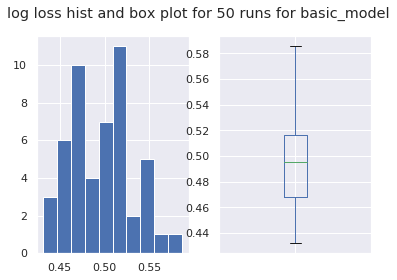

model_accuracy_mean : 0.42 secs
wrapper : ended


count    50.000000
mean      0.495220
std       0.035489
min       0.432000
25%       0.468250
50%       0.495500
75%       0.516500
max       0.586000
dtype: float64

In [32]:
@caller
@timer
def model_accuracy_mean(model=None, n=50, df=None) : 
    
    if not isinstance(df, pd.DataFrame): 
        df = build_df(DATA, TRAIN_FILE)

    if not model : 
        model = basic_model

    scores = pd.Series([model(df)[0] for i in range(n)])

    fix, ax = plt.subplots(1,2)
    scores.hist(ax=ax[0])
    pd.DataFrame({"":scores}).boxplot(ax=ax[1])
    plt.suptitle("log loss hist and box plot for {} runs for basic_model".format(n))
    plt.show()
    
    info(type(scores))
    info(type(range(n)))

    return scores.describe()


####


model_accuracy_mean(n=50)

wrapper : called
wrapper : called
build_df : 0.01 secs
wrapper : ended


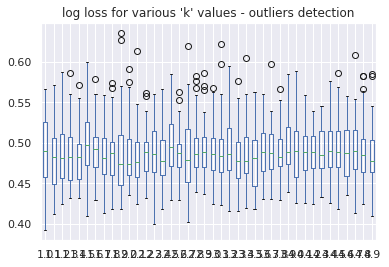

first_approch_of_feat_eng : 28.7 secs
wrapper : ended


In [33]:

@caller
@timer
def first_approch_of_feat_eng(model=None, n=20, df=None) : 

    if not isinstance(df, pd.DataFrame): 
        df = build_df(DATA, TRAIN_FILE)

    if not model : 
        model = basic_model
        
    k_list = np.arange(10, 50)/10
    
    outlier_df = lambda k : delete_outliers(df, k)
    results = [ [basic_model(outlier_df(k))[0] for k in k_list]
                   for i in range(n) ]
    
    results = pd.DataFrame(results, columns=k_list)
       
    results.boxplot()
    # plt.x_label("k") ; plt.y_label("log loss")
    plt.title("log loss for various 'k' values - outliers detection")
    plt.show()
    
    return results
    
    
####

results = first_approch_of_feat_eng(n=50)


In [34]:
# raw data

results.iloc[:10, :]


,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,...,4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9
0,0.513,0.441,0.448,0.502,0.525,0.468,0.441,0.448,0.448,0.627,...,0.465,0.473,0.468,0.508,0.488,0.470,0.445,0.464,0.495,0.472
1,0.495,0.449,0.464,0.499,0.499,0.410,0.495,0.459,0.491,0.439,...,0.497,0.474,0.476,0.433,0.515,0.514,0.445,0.489,0.439,0.487
2,0.529,0.429,0.489,0.438,0.470,0.462,0.488,0.470,0.529,0.433,...,0.535,0.525,0.500,0.468,0.491,0.493,0.501,0.465,0.499,0.476
3,0.462,0.536,0.467,0.540,0.496,0.473,0.496,0.475,0.476,0.476,...,0.545,0.469,0.539,0.489,0.483,0.508,0.451,0.528,0.496,0.531
4,0.529,0.463,0.444,0.492,0.449,0.533,0.503,0.496,0.500,0.443,...,0.451,0.439,0.452,0.511,0.502,0.486,0.448,0.466,0.457,0.497
5,0.433,0.520,0.544,0.512,0.472,0.543,0.472,0.455,0.437,0.636,...,0.500,0.494,0.488,0.503,0.468,0.488,0.487,0.491,0.488,0.435
6,0.515,0.485,0.438,0.528,0.509,0.507,0.534,0.447,0.439,0.437,...,0.450,0.456,0.515,0.471,0.507,0.499,0.455,0.511,0.485,0.483
7,0.392,0.501,0.430,0.461,0.447,0.508,0.464,0.463,0.448,0.517,...,0.474,0.430,0.534,0.467,0.468,0.481,0.487,0.453,0.564,0.493
8,0.463,0.440,0.533,0.524,0.442,0.476,0.460,0.502,0.500,0.429,...,0.475,0.465,0.458,0.502,0.493,0.551,0.517,0.539,0.498,0.492
9,0.461,0.452,0.482,0.463,0.475,0.567,0.482,0.413,0.467,0.554,...,0.589,0.533,0.453,0.534,0.474,0.569,0.497,0.500,0.506,0.475


In [38]:
# fancy results

results.describe().T.sort_values(by="50%", axis=0).iloc[:10, :]


,count,mean,std,min,25%,50%,75%,max
2.0,50.0,0.48752,0.037941,0.436,0.46000,0.4740,0.50475,0.591
1.9,50.0,0.48682,0.048804,0.418,0.44850,0.4745,0.50975,0.636
2.1,50.0,0.48344,0.035689,0.425,0.45850,0.4760,0.50075,0.613
4.9,50.0,0.48426,0.036278,0.410,0.46400,0.4775,0.50325,0.585
3.4,50.0,0.48570,0.037079,0.420,0.46250,0.4775,0.50775,0.605
2.4,50.0,0.48360,0.031723,0.419,0.46050,0.4775,0.50375,0.566
3.3,50.0,0.48184,0.036845,0.416,0.45675,0.4780,0.50125,0.577
2.7,50.0,0.48712,0.045973,0.403,0.45225,0.4790,0.51700,0.620
1.2,50.0,0.48406,0.036573,0.425,0.45700,0.4815,0.51150,0.588
1.7,50.0,0.48588,0.034436,0.413,0.46125,0.4820,0.50550,0.559


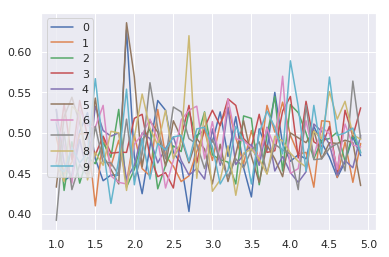

In [45]:
# graph 

results.iloc[:10, :].T.plot()

In [50]:
# without getting mad about results, we can see that it is not very easy to use
# maybe it could be much better if we only look at gain between normal and ehanced results

def outliers_lolo_gain(k, df, model=None, params=None) : 
    
    if not isinstance(df, pd.DataFrame) : 
        df = build_df(DATA, TRAIN_FILE)

    if not model :  model = LogisticRegression()
        
    if not params : params = dict()

    grid = GridSearchCV(model, params, cv = 5, n_jobs=3, scoring="accuracy")
        
    # init lolo
    X_tr, X_te, y_tr, y_te = split(*return_X_y(df))  
    grid.fit(X_tr, y_tr)   
    y_pred = grid.predict_proba(X_te)[:, 1]
    init_lolo = lolo = log_loss(y_te, y_pred)

    # new lolo
    X_tr, X_te, y_tr, y_te = split(*return_X_y(delete_outliers(df, k)))
    grid.fit(X_tr, y_tr)   
    y_pred = grid.predict_proba(X_te)[:, 1]
    new_lolo = log_loss(y_te, y_pred)
    
    return round((init_lolo - new_lolo) / init_lolo,3)



In [ ]:
# and here we have our benchmark function which return log loss gain for each k value

from sklearn.model_selection import GridSearchCV

def benchmark_various_outliers( n=20, df=None, params=None, 
                                        model=None, outliers_list=None) : 
    
    if not isinstance(df, pd.DataFrame) : 
        df = build_df(DATA, TRAIN_FILE)

    if not model : 
        model = LogisticRegression()
        
    if not params : 
        params = dict()

    if not outliers_list : 
        outliers_list = np.arange(0.1,5,0.1).round(1)

    results = [ [outliers_lolo_gain(k, df, model, params) for k in outliers_list]
                     for _ in range(n)]
    
    results = pd.DataFrame(results, columns=outliers_list)
    
    return results


####

results = benchmark_various_outliers(50)


wrapper : called
build_df : 0.01 secs
wrapper : ended


In [ ]:
# raw results 

results.iloc[:10, :]



In [ ]:
# how to have global stats ?

def print_gobal_stats(results) : 

    print("mean      : ", round(results.mean().mean(),3))
    print("median    : ", round(results.median().median(),3))
    print("25%       : ", round(results.quantile(0.25).quantile(0.25),3))
    print("75%       : ", round(results.quantile(0.75).quantile(0.75),3))
    print("min       : ", round(results.min().min(),3))
    print("max       : ", round(results.max().max(),3))
    
    
####

print_gobal_stats(results)


In [ ]:
# graph 

results.boxplot()


In [ ]:
# fancy results

results.describe().T.sort_values(by="50%", ascending=False).iloc[:10, :]


In [ ]:
# graph 

results.iloc[:10, :].T.plot()


In [ ]:
# last graph 

results.describe().T.loc[:,["mean", "50%"]].plot()



In [ ]:
# can we say that outliers detection and cleaning has a significant impact regarding our final score? 
# the answer is of course : "No"

In [ ]:
# conclusion

# We could see through this first study that we have a dataset quite simple, allowing our first approach 
# to have pretty good results.

# Our base model offers a performance of 0.5 and the impact of the ouliers on the model's performance 
# seems at first glance quite low.

# Having a fairly simple dataset, the possibilities for improving the models will not be that simple due 
# to the small number of variables and the small size of the dataset : the possibilities offered by 
# the feature engineering are indeed quite low.


In [38]:
########################################################################################################
########################################################################################################

# 02-starting_ML.py

########################################################################################################
########################################################################################################


# In this third part we will finally start to make real machine learning. We will first code a high-level
# function to handle the tests of the different models.

# We will then benchmark the different classification models as well as the impact of the different meta 
# variables on the relevance of the basic model: number of folds, preprocessing, scoring method, clips
# of the predicted values, etc.

# This work is clearly laborious, but its successful execution depends on our ability to really push 
# our model at best.


In [39]:
# import

from math import ceil
import itertools as it
from collections import OrderedDict, Iterable

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC

# from first_naive_models import *


In [40]:
# let's define a new decorator that will allow us to beeper during long tests of algo sessions

def beeper(funct) : 
    """decorator to beep when a long algo as finished"""

    def wrapper(*args, **kwargs) : 
        
        res = funct(*args, **kwargs)

        freq=440
        duration=3
        cmd = 'play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq)
        os.system(cmd)

        return res

    return wrapper


In [41]:
# Please find here our meta GridSearchCV. For each params grid, it initiates a df, split 
# test / train data, launches the grid search, and returns the model and the log loss in final output

# @timer
# @caller
def run_GSCV(   model=None,     params=None, 
                df=None,        tup=None,
                cv=0,           n_jobs=None,
                scoring=None,   test_size=None, 
                verbose=None,   debug_mode=None) : 

    # init default params
    if not model        : model = LogisticRegression()
    else : 
        try             : model = model()
        except          : pass

    is_df               = isinstance(df, pd.DataFrame)
    if not is_df        : df = build_df(DATA, TRAIN_FILE)
    if not params       : params = dict()
    if not cv           : cv=5
    if not n_jobs       : n_jobs = 6
    if not scoring      : scoring = "accuracy"
    if not verbose      : verbose = 1
    if not test_size    : test_size = 0.33
    if not debug_mode   : debug_mode = False
    grid = None

    if not tup : # prepare X, y
        X,y                 = return_X_y(df)
        X_tr,X_te,y_tr,y_te = split(X,y, test_size)
    else :
        X_tr,X_te,y_tr,y_te = tup
    
    info(model.__class__)
    try : # init grid      
        grid        = GridSearchCV( estimator=model, 
                                    param_grid=params,  
                                    cv=cv, 
                                    n_jobs=n_jobs,
                                    scoring=scoring, 
                                    verbose=verbose)
        info("grid init ok")
        info(grid)

    except Exception as e : 
        info("grit init went wrong")
        if debug_mode : input()
        raise(e)

    try : # fit
        grid.fit(X_tr, y_tr)
        info("grid fit OK")
        info(grid.best_estimator_)
        info(grid.best_score_)
        info(grid.best_params_)

    except Exception as e : 
        info("grit fit went wrong")
        if debug_mode : input()
        raise(e)

    try : # pred
        y_pred = grid.predict_proba(X_te)
        y_pred = y_pred[:,1]
        info("pred OK")
        info("run_GSCV 0") 
    
    except Exception as e : 
        info("pred went wrong")
        info("maybe predict_proba do not exists just predict")       
        try : 
            y_pred = grid.predict(X_te)
            info("second pred Method OK")
            info("run_GSCV 1")

        except Exception as e : 
            info("2nd pred method went wrong")
            if debug_mode : input()
            raise(e)

    try : # compute log_loss as 'lolo' 
        lolo = log_loss(y_te, y_pred).round(3)
        info("lolo ok")
        info(lolo)

    except Exception as e : 
        info("lolo went wrong")
        if debug_mode : input()
        raise(e)

    # return lolo and grid
    if isinstance(lolo, float) and grid : 
        return lolo, grid
    # else raise Error
    raise ValueError("lolo and/or grid error")
    
    
####

lolo, grid = run_GSCV()


wrapper : called
build_df : 0.01 secs
wrapper : ended
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


In [42]:
print(lolo)
print(grid)

0.55
GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=6, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)


In [43]:
# Find here the models we will try and test

COLUMNS = [     "LR",       "RC",
                "SVC",      # "Nu",
                "KNN",
                "DT", 
                "RF", 
                "Ada", 
                "Per",      "MLP"   ]

MODELS = [      LogisticRegression, RidgeClassifier,
                LinearSVC, # NuSVC,
                KNeighborsClassifier,
                DecisionTreeClassifier,
                RandomForestClassifier,
                AdaBoostClassifier,
                Perceptron, MLPClassifier   ]


In [44]:
# we now will benchmark various models, without any feat eng. or meta params. Just have a first look...

# @timer
def benchmark_various_models(  n=5, df=None, graph=True, params=None,
                                    models = MODELS, columns= COLUMNS) : 

    if not isinstance(df, pd.DataFrame): 
        df = build_df(DATA, TRAIN_FILE)

    if len(models) != len(columns) : 
        raise ValueError("lens not goods")

    if not params : params = dict()    

    results = [     pd.Series([run_GSCV(m, params, df)[0] for m in models], 
                        index=columns) for i in range(n)]
    
    results = pd.DataFrame(results, columns=columns)

    return results


####


results = benchmark_various_models(50)


wrapper : called
build_df : 0.01 secs
wrapper : ended
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.4s finished


In [ ]:
# print out raw values

results.iloc[:10, :]


In [45]:
# lets have fancy representation of our results

_results = results.describe().T.sort_values(by="50%")
_results


,count,mean,std,min,25%,50%,75%,max
LR,50.0,0.48608,0.036468,0.419,0.45850,0.4855,0.51150,0.569
MLP,50.0,0.63288,0.157822,0.433,0.51450,0.6025,0.71550,1.144
Ada,50.0,0.68144,0.004224,0.664,0.68000,0.6820,0.68400,0.687
RF,50.0,2.34806,0.616976,1.186,1.91850,2.3350,2.74400,3.606
KNN,50.0,2.67004,0.716420,1.472,2.16400,2.6290,3.05975,4.313
RC,50.0,8.01444,0.770235,6.148,7.59500,8.0470,8.49900,9.946
SVC,50.0,8.86808,2.549847,5.967,7.50450,8.2275,9.17700,17.541
Per,50.0,10.62216,4.800997,5.425,7.82125,8.8610,12.11600,26.221
DT,50.0,9.01604,0.812613,7.141,8.42575,9.1270,9.49200,10.751


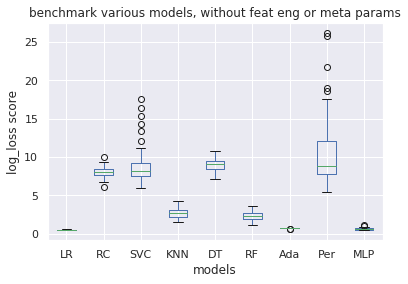

In [46]:
# graph it 

results.boxplot()
plt.xlabel("models")
plt.ylabel("log_loss score")
plt.title("benchmark various models, without feat eng or meta params")
plt.show()


In [47]:
# An other test could benchmark various k values of outliers threshold

def benchmark_various_outliers(     n=5, df=None, graph=True, params=None,
                                    k_list=None, model=None ) :

    if not isinstance(df, pd.DataFrame): 
        df = build_df(DATA, TRAIN_FILE)

    if not isinstance(k_list, Iterable) : 
        k_list = np.arange(1, 5, 0.1,).round(1) 

    if not model : model = LogisticRegression

    if not params : params = dict() 

    results = [ pd.Series([run_GSCV(model, params, delete_outliers(df, k))[0] for k in k_list], 
                        index=k_list) for i in range(n)]
    
    results = pd.DataFrame(results, columns=k_list)

    return results


####

results = benchmark_various_outliers(50)


wrapper : called
build_df : 0.01 secs
wrapper : ended
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


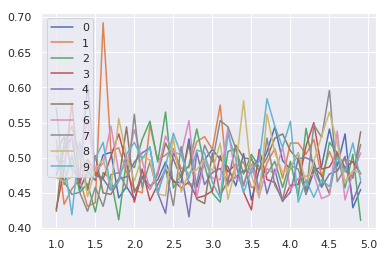

In [48]:
# raw results

results.iloc[:10, :]


In [49]:
def print_gobal_stats(results) : 

    print("mean      : ", round(results.mean().mean(),3))
    print("median    : ", round(results.median().median(),3))
    print("25%       : ", round(results.quantile(0.25).quantile(0.25),3))
    print("75%       : ", round(results.quantile(0.75).quantile(0.75),3))
    print("min       : ", round(results.min().min(),3))
    print("max       : ", round(results.max().max(),3))
    
    
####

print_gobal_stats(results)

mean      :  0.487
median    :  0.484
25%       :  0.457
75%       :  0.513
min       :  0.411
max       :  0.692


In [51]:
# lets have fancy representation of our results

_results = results.describe().T
_results.iloc[:10, :]


,count,mean,std,min,25%,50%,75%,max
1.0,10.0,0.4892,0.043967,0.424,0.47275,0.4930,0.50675,0.571
1.1,10.0,0.4866,0.030060,0.434,0.46600,0.4895,0.50850,0.530
1.2,10.0,0.4966,0.049428,0.419,0.46025,0.4935,0.53000,0.578
1.3,10.0,0.4793,0.026571,0.451,0.45725,0.4690,0.50200,0.522
1.4,10.0,0.4828,0.056872,0.424,0.44725,0.4685,0.49350,0.605
1.5,10.0,0.4706,0.025522,0.423,0.46050,0.4770,0.48325,0.503
1.6,10.0,0.5008,0.072209,0.431,0.47000,0.4855,0.50250,0.692
1.7,10.0,0.4824,0.032236,0.448,0.45525,0.4730,0.50650,0.545
1.8,10.0,0.4821,0.042475,0.412,0.46700,0.4745,0.50525,0.556
1.9,10.0,0.4900,0.025346,0.457,0.47475,0.4915,0.50075,0.544


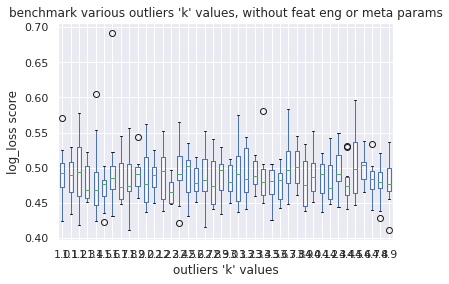

In [52]:
# graph it 

results.boxplot()
plt.xlabel("outliers 'k' values")
plt.ylabel("log_loss score")
plt.title("benchmark various outliers 'k' values, without feat eng or meta params")
plt.show()


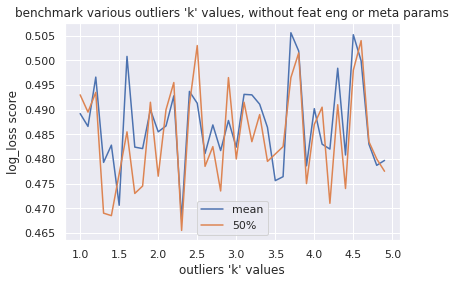

In [53]:
# graph it 

results.describe().T.loc[:, ["mean", "50%"]].plot()
plt.xlabel("outliers 'k' values")
plt.ylabel("log_loss score")
plt.title("benchmark various outliers 'k' values, without feat eng or meta params")
plt.show()


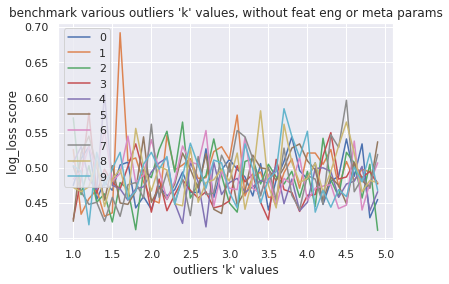

In [54]:
# graph

results.T.iloc[:, :10].plot()
plt.xlabel("outliers 'k' values")
plt.ylabel("log_loss score")
plt.title("benchmark various outliers 'k' values, without feat eng or meta params")
plt.show()


In [55]:
# Now we will study various features transformation.
# First let's define some useful function

def transform_df(Tool, df=None, **kwargs) :

    if not isinstance(df, pd.DataFrame) : 
        df = build_df(DATA, TRAIN_FILE)

    if "target" in df : 
        X = df.drop("target", axis=1)
        y = df.target
    else : 
        X = df

    tool = Tool()
    _X = tool.fit_transform(X)
    _X = pd.DataFrame(_X, columns=X.columns, index=X.index)
    
    if "target" in df :
        _df = _X
        _df["target"] = y
    else : 
        _df = _X

    return _df


def nothing(df=None) : 
    
    if not isinstance(df, pd.DataFrame) : 
        df = build_df(DATA, TRAIN_FILE)

    return df


def standscale(df=None) : 

    if not isinstance(df, pd.DataFrame) : 
        df = build_df(DATA, TRAIN_FILE)

    return transform_df(StandardScaler, df)



def normalize(df=None, norm=None) : 

    if not isinstance(df, pd.DataFrame) : 
        df = build_df(DATA, TRAIN_FILE)

    if not norm : 
        norm='l2'

    return transform_df(StandardScaler, df) 
    

def min_max(df=None) : 

    if not isinstance(df, pd.DataFrame) : 
        df = build_df(DATA, TRAIN_FILE)

    return transform_df(MinMaxScaler, df)


def min_max_and_standsacle(df=None) : 

    return standscale(min_max(df))
    

In [56]:
# transorm list and index (str values)

TRANSFORM_LIST = [nothing, normalize, standscale, min_max, min_max_and_standsacle]
TRANSFORM_INDEX = ["nothing", "normalize", "standscale", "min_max", "mimax+stdsca"]


In [57]:
# here we have our benchmark function 

def benchmark_various_transform(   n=10, df=None, graph=True, params=None, model=None,
                                    transform_list=TRANSFORM_LIST, transform_index = TRANSFORM_INDEX) : 

    if not isinstance(df, pd.DataFrame): 
        df = build_df(DATA, TRAIN_FILE)

    if not model : model =  LogisticRegression

    if not params : params = dict() 

    if len(transform_list) != len(transform_index) : 
        raise ValueError("lens not goods")

    results = [     pd.Series([run_GSCV(model, params, transf(df))[0] for transf in transform_list], 
                        index=transform_index) for i in range(n)]
    
    results = pd.DataFrame(results, columns=transform_index)

    return results


####


results = benchmark_various_transform(50)


wrapper : called
build_df : 0.02 secs
wrapper : ended
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


In [58]:
# raw results 

results.iloc[:10, :]


,nothing,normalize,standscale,min_max,mimax+stdsca
0,0.521,0.469,0.510,0.485,0.425
1,0.492,0.455,0.456,0.498,0.560
2,0.471,0.512,0.445,0.491,0.508
3,0.503,0.458,0.474,0.517,0.512
4,0.519,0.506,0.551,0.557,0.571
5,0.534,0.522,0.473,0.522,0.444
6,0.489,0.485,0.495,0.501,0.506
7,0.481,0.541,0.507,0.510,0.488
8,0.474,0.471,0.513,0.563,0.456
9,0.465,0.538,0.463,0.514,0.482


In [59]:
# gobal results

print_gobal_stats(results)


mean      :  0.498
median    :  0.496
25%       :  0.466
75%       :  0.52
min       :  0.425
max       :  0.571


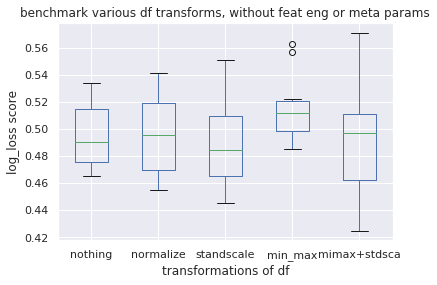

In [60]:
# graph  

results.boxplot()
plt.xlabel("transformations of df")
plt.ylabel("log_loss score")
plt.title("benchmark various df transforms, without feat eng or meta params")
plt.show()


In [61]:
# fancy results

_results = results.describe().T.sort_values(by="50%")
_results


,count,mean,std,min,25%,50%,75%,max
standscale,10.0,0.4887,0.032321,0.445,0.46550,0.4845,0.50925,0.551
nothing,10.0,0.4949,0.023558,0.465,0.47575,0.4905,0.51500,0.534
normalize,10.0,0.4957,0.032352,0.455,0.46950,0.4955,0.51950,0.541
mimax+stdsca,10.0,0.4952,0.046927,0.425,0.46250,0.4970,0.51100,0.571
min_max,10.0,0.5158,0.026038,0.485,0.49875,0.5120,0.52075,0.563


Text(0.5,1,'benchmark various df transforms, without feat eng or meta params')

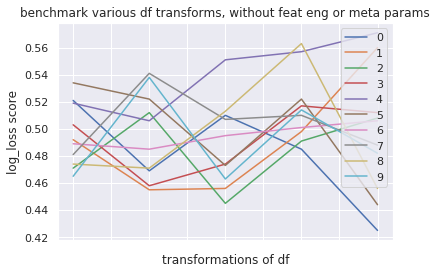

In [62]:
# graph 

results.T.iloc[:,:10].plot()
plt.xlabel("transformations of df")
plt.ylabel("log_loss score")
plt.title("benchmark various df transforms, without feat eng or meta params")


In [63]:
# ok let's do the same thing for scoring ! 

def benchmark_various_scoring(  n=5, df=None, graph=True, params=None, model=None,
                                scoring_list=None) : 

    if not isinstance(df, pd.DataFrame): 
        df = build_df(DATA, TRAIN_FILE)

    if not scoring_list : 
        scoring_list = ['accuracy', 'neg_log_loss', 'f1', 'average_precision', 'precision', 'recall', "roc_auc"]

    if not model : model = LogisticRegression

    if not params : params = dict() 

    results = [ pd.Series([run_GSCV(model, params, df, scoring=s)[0] for s in scoring_list], 
                        index=scoring_list) for i in range(n)]
    
    results = pd.DataFrame(results, columns=scoring_list)

    return results


####

results = benchmark_various_scoring(10)


wrapper : called
build_df : 0.01 secs
wrapper : ended
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


In [64]:
# raw results

results.iloc[:10, :]


,accuracy,neg_log_loss,f1,average_precision,precision,recall,roc_auc
0,0.522,0.442,0.484,0.496,0.472,0.456,0.506
1,0.464,0.534,0.488,0.468,0.486,0.465,0.501
2,0.551,0.473,0.566,0.459,0.435,0.496,0.493
3,0.454,0.471,0.518,0.535,0.508,0.492,0.455
4,0.465,0.485,0.458,0.460,0.477,0.519,0.526
5,0.487,0.456,0.479,0.496,0.510,0.454,0.497
6,0.477,0.506,0.504,0.446,0.501,0.536,0.503
7,0.486,0.460,0.479,0.444,0.431,0.508,0.553
8,0.512,0.513,0.495,0.524,0.494,0.515,0.504
9,0.451,0.490,0.487,0.459,0.500,0.455,0.537


In [65]:
# gobal results

print_gobal_stats(results)


mean      :  0.489
median    :  0.488
25%       :  0.461
75%       :  0.51
min       :  0.431
max       :  0.566


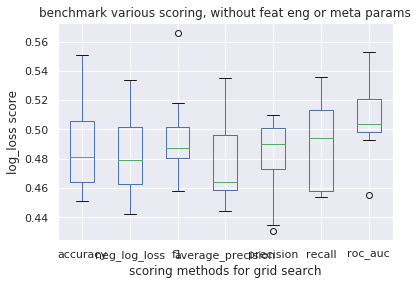

In [66]:
# graph 

results.boxplot()
plt.xlabel("scoring methods for grid search")
plt.ylabel("log_loss score")
plt.title("benchmark various scoring, without feat eng or meta params")
plt.show()


In [67]:
# fancy results

_results = results.describe().T.sort_values(by="50%")
_results


,count,mean,std,min,25%,50%,75%,max
average_precision,10.0,0.4787,0.032204,0.444,0.45900,0.4640,0.49600,0.535
neg_log_loss,10.0,0.4830,0.028414,0.442,0.46275,0.4790,0.50200,0.534
accuracy,10.0,0.4869,0.032395,0.451,0.46425,0.4815,0.50575,0.551
f1,10.0,0.4958,0.029363,0.458,0.48025,0.4875,0.50175,0.566
precision,10.0,0.4814,0.028356,0.431,0.47325,0.4900,0.50075,0.510
recall,10.0,0.4896,0.030270,0.454,0.45825,0.4940,0.51325,0.536
roc_auc,10.0,0.5075,0.026743,0.455,0.49800,0.5035,0.52100,0.553


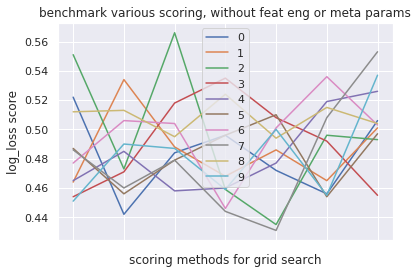

In [68]:
# graph 

results.T.iloc[:, :10].plot()
plt.xlabel("scoring methods for grid search")
plt.ylabel("log_loss score")
plt.title("benchmark various scoring, without feat eng or meta params")
plt.show()


In [69]:
# 'overkill' OK, let's be evil, we now are ready to benchmark Kfolds numbers and test/train size ! 

def benchmark_various_cv(   n=5, df=None, graph=True, params=None, model=None,
                            cv_list=None) : 

    if not isinstance(df, pd.DataFrame): 
        df = build_df(DATA, TRAIN_FILE)

    if not cv_list : 
        cv_list = [int(i) for i in np.arange(2,11, 1)]

    if not model : 
        model = LogisticRegression

    if not params : params = dict() 

    results = [ pd.Series([run_GSCV(model, params, df, cv=c)[0] for c in cv_list], 
                        index=cv_list) for i in range(n)]
    
    results = pd.DataFrame(results, columns=cv_list)

    return results


####

results = benchmark_various_cv(10)


wrapper : called
build_df : 0.01 secs
wrapper : ended
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed:    0.0s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=6)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   7 out of   7 | elapsed:    0.0s finished


Fitting 9 folds for each of 1 candidates, totalling 9 fits


[Parallel(n_jobs=6)]: Done   6 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Done   9 out of   9 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed:    0.0s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=6)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   7 out of   7 | elapsed:    0.0s finished


Fitting 9 folds for each of 1 candidates, totalling 9 fits


[Parallel(n_jobs=6)]: Done   6 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Done   9 out of   9 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed:    0.0s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=6)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   7 out of   7 | elapsed:    0.0s finished


Fitting 9 folds for each of 1 candidates, totalling 9 fits


[Parallel(n_jobs=6)]: Done   6 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Done   9 out of   9 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed:    0.0s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.1s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=6)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   7 out of   7 | elapsed:    0.0s finished


Fitting 9 folds for each of 1 candidates, totalling 9 fits


[Parallel(n_jobs=6)]: Done   6 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   8 out of   8 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Done   9 out of   9 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed:    0.0s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=6)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   7 out of   7 | elapsed:    0.0s finished


Fitting 9 folds for each of 1 candidates, totalling 9 fits


[Parallel(n_jobs=6)]: Done   6 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Done   9 out of   9 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed:    0.0s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=6)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   7 out of   7 | elapsed:    0.0s finished


Fitting 9 folds for each of 1 candidates, totalling 9 fits


[Parallel(n_jobs=6)]: Done   6 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Done   9 out of   9 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed:    0.0s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=6)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   7 out of   7 | elapsed:    0.0s finished


Fitting 9 folds for each of 1 candidates, totalling 9 fits


[Parallel(n_jobs=6)]: Done   6 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   8 out of   8 | elapsed:    0.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Done   9 out of   9 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed:    0.0s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=6)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   7 out of   7 | elapsed:    0.0s finished


Fitting 9 folds for each of 1 candidates, totalling 9 fits


[Parallel(n_jobs=6)]: Done   6 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Done   9 out of   9 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed:    0.0s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=6)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   7 out of   7 | elapsed:    0.0s finished


Fitting 9 folds for each of 1 candidates, totalling 9 fits


[Parallel(n_jobs=6)]: Done   6 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Done   9 out of   9 | elapsed:    0.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed:    0.0s finished


Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.0s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=6)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   7 out of   7 | elapsed:    0.0s finished


Fitting 9 folds for each of 1 candidates, totalling 9 fits


[Parallel(n_jobs=6)]: Done   6 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s finished


In [70]:
# raw results

results.head()


,2,3,4,5,6,7,8,9,10
0,0.522,0.490,0.525,0.528,0.482,0.552,0.463,0.592,0.506
1,0.563,0.521,0.537,0.489,0.585,0.456,0.467,0.449,0.530
2,0.456,0.514,0.594,0.457,0.524,0.494,0.446,0.472,0.476
3,0.479,0.511,0.518,0.505,0.551,0.524,0.504,0.442,0.451
4,0.527,0.498,0.515,0.499,0.531,0.456,0.479,0.489,0.494


In [71]:
# gobal results

print_gobal_stats(results)


mean      :  0.499
median    :  0.498
25%       :  0.467
75%       :  0.526
min       :  0.419
max       :  0.594


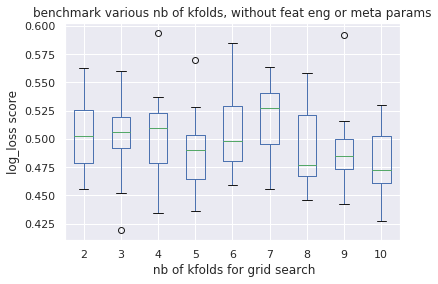

In [72]:
# graph

results.boxplot()
plt.xlabel(" nb of kfolds for grid search")
plt.ylabel("log_loss score")
plt.title("benchmark various nb of kfolds, without feat eng or meta params")
plt.show()


In [73]:
# fancy results

_results = results.describe().T.sort_values(by="50%")
_results


,count,mean,std,min,25%,50%,75%,max
10,10.0,0.4806,0.033896,0.427,0.46125,0.4725,0.50300,0.530
8,10.0,0.4920,0.036748,0.446,0.46700,0.4770,0.52125,0.558
9,10.0,0.4914,0.041823,0.442,0.47375,0.4850,0.50000,0.592
5,10.0,0.4915,0.038848,0.436,0.46475,0.4900,0.50350,0.570
6,10.0,0.5071,0.040358,0.459,0.48050,0.4980,0.52925,0.585
2,10.0,0.5046,0.033988,0.456,0.47825,0.5030,0.52575,0.563
3,10.0,0.5011,0.041286,0.419,0.49200,0.5060,0.51925,0.560
4,10.0,0.5069,0.043334,0.434,0.47875,0.5095,0.52325,0.594
7,10.0,0.5151,0.037805,0.456,0.49525,0.5275,0.54075,0.564


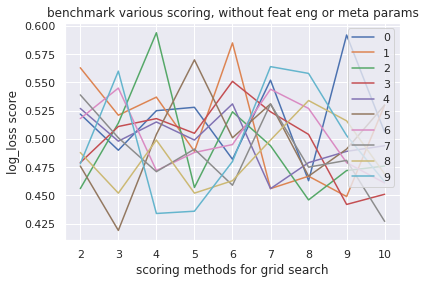

In [74]:
# graph 

results.T.iloc[:, :10].plot()
plt.xlabel("scoring methods for grid search")
plt.ylabel("log_loss score")
plt.title("benchmark various scoring, without feat eng or meta params")
plt.show()


In [75]:
# 'overkill' idem for test/train ratio

def benchmark_various_test_size(   n=5, df=None, graph=True, params=None, model=None,
                                   test_size_list=None) : 

    if not isinstance(df, pd.DataFrame): 
        df = build_df(DATA, TRAIN_FILE)

    if not test_size_list : 
        test_size_list =  [round(float(i), 2) for i in (np.arange(20, 41, 1) /100)]

    if not model : 
        model = LogisticRegression

    if not params : params = dict() 

    results = [ pd.Series([run_GSCV(model, params, df, test_size=t)[0] for t in test_size_list], 
                        index=test_size_list) for i in range(n)]
    
    results = pd.DataFrame(results, columns=test_size_list)

    return results


#### 

results = benchmark_various_test_size(10)


wrapper : called
build_df : 0.01 secs
wrapper : ended
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


In [76]:
# raw results

results.iloc[:10, :]


,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,...,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4
0,0.473,0.553,0.483,0.526,0.464,0.508,0.503,0.524,0.497,0.440,...,0.478,0.496,0.501,0.459,0.503,0.482,0.450,0.491,0.476,0.527
1,0.553,0.446,0.474,0.440,0.618,0.472,0.446,0.445,0.483,0.490,...,0.456,0.500,0.501,0.494,0.516,0.517,0.496,0.463,0.523,0.520
2,0.579,0.542,0.519,0.558,0.412,0.506,0.455,0.515,0.563,0.511,...,0.518,0.465,0.432,0.495,0.503,0.489,0.495,0.539,0.476,0.516
3,0.540,0.512,0.520,0.480,0.447,0.452,0.487,0.439,0.473,0.500,...,0.483,0.477,0.518,0.454,0.535,0.485,0.476,0.494,0.509,0.532
4,0.431,0.478,0.473,0.533,0.456,0.508,0.448,0.553,0.503,0.493,...,0.481,0.500,0.560,0.429,0.493,0.496,0.560,0.507,0.484,0.515
5,0.417,0.574,0.479,0.436,0.451,0.441,0.510,0.475,0.545,0.636,...,0.452,0.470,0.461,0.487,0.507,0.488,0.469,0.494,0.519,0.499
6,0.579,0.483,0.453,0.471,0.488,0.512,0.445,0.454,0.468,0.478,...,0.536,0.456,0.466,0.490,0.466,0.491,0.507,0.476,0.495,0.503
7,0.614,0.509,0.566,0.527,0.476,0.473,0.561,0.461,0.421,0.592,...,0.486,0.500,0.478,0.505,0.510,0.515,0.475,0.497,0.472,0.504
8,0.466,0.542,0.462,0.524,0.580,0.546,0.484,0.481,0.490,0.461,...,0.521,0.483,0.560,0.555,0.481,0.464,0.465,0.513,0.549,0.460
9,0.512,0.463,0.435,0.419,0.464,0.496,0.485,0.499,0.484,0.513,...,0.503,0.526,0.489,0.479,0.543,0.543,0.520,0.590,0.452,0.477


In [77]:
# gobal results

print_gobal_stats(results)


mean      :  0.495
median    :  0.49
25%       :  0.464
75%       :  0.514
min       :  0.412
max       :  0.636


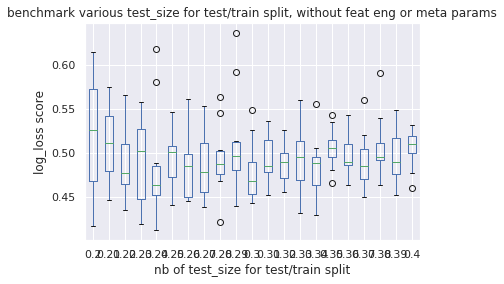

In [78]:
# graph 

results.boxplot()
plt.xlabel("nb of test_size for test/train split")
plt.ylabel("log_loss score")
plt.title("benchmark various test_size for test/train split, without feat eng or meta params")
plt.show()


In [79]:
# fancy results

_results = results.describe().T.sort_values(by="50%")
_results


,count,mean,std,min,25%,50%,75%,max
0.24,10.0,0.4856,0.063642,0.412,0.45225,0.4640,0.48500,0.618
0.30,10.0,0.4784,0.034690,0.443,0.45350,0.4685,0.48900,0.549
0.22,10.0,0.4864,0.038414,0.435,0.46475,0.4765,0.51000,0.566
0.27,10.0,0.4846,0.037429,0.439,0.45575,0.4780,0.51100,0.553
0.31,10.0,0.4914,0.027690,0.452,0.47875,0.4845,0.51425,0.536
0.26,10.0,0.4824,0.036594,0.445,0.44975,0.4845,0.49900,0.561
0.37,10.0,0.4913,0.032007,0.450,0.47050,0.4855,0.50425,0.560
0.28,10.0,0.4927,0.039607,0.421,0.47550,0.4870,0.50150,0.563
0.34,10.0,0.4847,0.033859,0.429,0.46400,0.4885,0.49475,0.555
0.39,10.0,0.4955,0.029232,0.452,0.47600,0.4895,0.51650,0.549


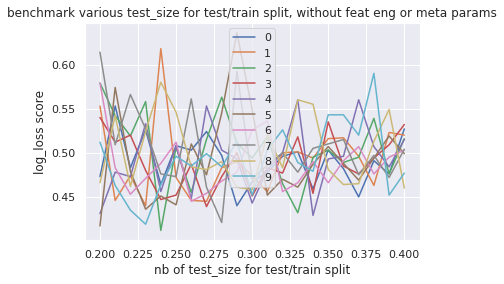

In [80]:
# graph 

results.T.iloc[:, :10].plot()
plt.xlabel("nb of test_size for test/train split")
plt.ylabel("log_loss score")
plt.title("benchmark various test_size for test/train split, without feat eng or meta params")
plt.show()


In [81]:
# we now will try to ehance our output with thresholding our predictions

def threshold_log_loss(y_pred, y_test=None, x=0.05) : 
    
    if not isinstance(y_pred, Iterable) : 
        raise ValueError("y_pred has to be a pd.Series")
        
    if isinstance(y_test, pd.Series) :  
        info(log_loss(y_test, y_pred))
    
    if not(0.000 <= x <= 0.4999 ) :
        raise ValueError("threshold must be 0.00 --> 0.5")

    info(x)
 
    y_pred = pd.Series(y_pred)
    y_pred = y_pred.apply(lambda i : x if i<= x else i)
    
    x = round((1-x), 2)
    y_pred = y_pred.apply(lambda i : x if i>= x else i)

    if isinstance(y_test, pd.Series) :  
        info(log_loss(y_test, y_pred))
    
    return y_pred


In [82]:
# compute lolo gain for one k threshold

def threshold_lolo_gain(k, df, model=None, params=None) : 
    
    if not isinstance(df, pd.DataFrame) : 
        df = build_df(DATA, TRAIN_FILE)

    if not model : 
        model = LogisticRegression()
        
    if not params : 
        params = dict()

    X,y = return_X_y(df)
    X_tr, X_te, y_tr, y_te = split(X, y)
    y_test = y_te
    
    grid = GridSearchCV(model, params, 
                        cv = 10, 
                        n_jobs=6,
                        scoring="accuracy")
    
    grid.fit(X_tr, y_tr)   
    y_pred = grid.predict_proba(X_te)
    y_pred = y_pred[:, 1]

    init_lolo = lolo = log_loss(y_test, y_pred)

    y_pred = threshold_log_loss(y_pred, k)
    new_lolo = log_loss(y_test, y_pred)

    return round((init_lolo - new_lolo) / init_lolo,3)



In [ ]:
# idem for every threshold between 0.0 and 0.5

def benchmark_various_threshold_lolo(   n=20, df=None, graph=True, params=None, 
                                        model=None, threshold_list=None) : 
    
    if not isinstance(df, pd.DataFrame) : 
        df = build_df(DATA, TRAIN_FILE)

    if not model : 
        model = LogisticRegression()
        
    if not params : 
        params = dict()

    if not threshold_list : 
        threshold_list = [round(i/100, 2) for i in range(1,50)]
        # threshold_list = [round(i/1000, 3) for i in range(10,101)]
        # threshold_list = [round(i/1000, 3) for i in range(10,500, 5)]
    results = [ [threshold_lolo_gain(k, df, model, params) for k in threshold_list]
                     for _ in range(n)]
    
    results = pd.DataFrame(results, columns=threshold_list)
    
    return results


####

results = benchmark_various_threshold_lolo(50)

wrapper : called
build_df : 0.01 secs
wrapper : ended


In [ ]:
# raw results

results.iloc[:10, :]


In [ ]:
# gobal results

print_gobal_stats(results)

In [ ]:
# graph 

results.boxplot()


In [ ]:
# fancy results 

_results = results.describe().T.sort_values(by="50%", axis=0, ascending=False).iloc[:10, :]
_results


In [ ]:
# graph

results.iloc[:10, :].T.plot()


In [ ]:
# we now will study the impact of softmax method on our output predictions
# famous soft max method is the exponetial soft max

def exp_softmax(x):
    

    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()



In [ ]:
# we will compute our method, which is a linear soft max method

def lin_softmax(ser, k=2, p=0.1, t=0.5) : 
    
    is_u = lambda x : True if x >t else False
    dist_med = lambda x : abs(x -t) / t

    coef = lambda x :  p * (k * (t-dist_med(x)))

    _soft_extr = lambda x : x if dist_med(x)>= t else (x + coef(x) if is_u(x) else x - coef(x))

    return [_soft_extr(i) for i in ser]


In [ ]:
# Conclusion

# After a full study of the different possibilities we have, here are the conclusions:

# - 3 models are very good, LogisticRegression, AdaBoost, and MLP (neural networks).
# - for obvious reasons we will first investigate LogisticRegression model
# - outlier threshold (1.3) and stand-up tranform of the dataset does not really improve our score but allows for more consistent results and can outperform punctually
# - roc_auc and average_precision allow a slightly better score
# - Kfolds number, test / train rate have no impact on our performance


In [ ]:
#############################################################
#############################################################

# 03-finding_good_models.py

#############################################################
#############################################################


"""
zaoidozdoja
dnzadzddzdaza
dzadda
dzadzadzadzad
dzadzadadza
"""

In [ ]:
# import

# from starting_ML import *


In [ ]:

def combine_param_dict(d) : 

    d = OrderedDict(d)
    combinations = it.product(*(d[feat] for feat in d))
    combinations = list(combinations)

    d = [{i:[j,] for i,j in zip(d.keys(), I)} for I in combinations ]

    return d


####

d = {"a" : ["a","b","c"], "b": [0,1,2,3,4]}
d = combine_param_dict(d)
d

In [ ]:
def grid_LogisticRegression(df=None, param=None,
                            model=LogisticRegression) : 

    default_params  = { "penalty":["l2"],
                        "dual":[False],
                        "tol":[0.0001],
                        "C":[1.0],
                        "fit_intercept":[True],
                        "intercept_scaling":[1],
                        "class_weight":[None],
                        "solver":["liblinear"],
                        "max_iter":[100],
                        "multi_class":["ovr"],
                        "warm_start":[False],   }

    all_params      = { "penalty":["l1", "l2"],
                        "dual":[True, False],
                        "tol":[0.0001, 0.001, 0.1, 1],                   # consider also np.logspace(-6, 2, 9)
                        "C":[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],      # consider also np.logspace(-3, 1, 40)
                        "fit_intercept":[True],
                        "intercept_scaling":[1],
                        "class_weight":[None],
                        "solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
                        "max_iter":[100, 1000],   # consider also np.logspace(3, 5, 3)
                        "multi_class":["ovr", "multinomial"],
                        "warm_start":[False, True],   }

    all_params2     = { "penalty":["l1", "l2"],
                        "dual":[True, False],
                        "tol":[0.0001, 0.001, 0.01],            # consider also np.logspace(-6, 2, 9)
                        "C":[0.001, 0.01, 0.1, 1, 10],      # consider also np.logspace(-3, 1, 40)
                        "fit_intercept":[True],
                        "intercept_scaling":[1],
                        "class_weight":[None],
                        "solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
                        "max_iter":[100],                   # consider also np.logspace(3, 5, 3)
                        "multi_class":["ovr", "multinomial"],
                        "warm_start":[True, False],   }

    none_params     = {}

    if not param :  param = none_params
    else  :         param = best_params_2

    # lolo, grid       = run_GSCV(model, param, None)

    # return lolo, grid

In [ ]:
all_params     =      { "penalty":["l1", "l2"],
                        "dual":[True, False],
                        "tol":[0.0001, 0.001],            # consider also np.logspace(-6, 2, 9)
                        "C":[ 0.01, 0.1, 1, 10],      # consider also np.logspace(-3, 1, 40)
                        "fit_intercept":[True],
                        "intercept_scaling":[1],
                        "class_weight":[None],
                        "solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
                        "max_iter":[100],                   # consider also np.logspace(3, 5, 3)
                        "multi_class":["ovr", "multinomial"],
                        "warm_start":[True, False],   }

In [ ]:

def _mean(x) : 
    
    if not isinstance(x, Iterable) : 
        raise ValueError("x must be iter")

    return round(float(sum(x) / len(x)), 3)


def _med(x) : 

    x = sorted(x)

    if not (len(x) % 2) : 
        idx     = len(x) /2
        idx_u   = ceil(idx)
        idx_d   = ceil(idx) - 1

        med = _mean([x[idx_u], x[idx_d]])

    else :
        idx = int(len(x)/2)
        med = x[idx]

    return round(med, 3)


def _mix(x) : 

    mea_x = _mean(x)
    med_x = _med(x)

    return _mean([mea_x, med_x]) 


####

ser = pd.Series([1,2,3,4,5,6,7,8, 10, 1000])
print(ser.mean())
print(ser.median())
print(pd.Series([ser.mean(), ser.median()]).mean())

print()

print(_mean(ser))
print(_med(ser))
print(_mix(ser))

In [ ]:

# @timer
def benchmark_various_params(model, params, n=None, df=None, 
                             meth=None, save=True) : 


    if not isinstance(df, pd.DataFrame): 
        df = build_df(DATA, TRAIN_FILE)

    if not n : 
        n = 10

    if      meth == None   : meth = _mix
    elif    meth == "mean" : meth = _mean
    elif    meth == "med"  : meth = _med
    elif    meth == "mix"  : meth = _mix
    else                   : raise ValueError("not good method") 

    if save : 
        txt =   "init file         \n"
        txt +=  "model :   {}      \n".format(model)
        txt +=  "params :  {}      \n".format(params)
        txt +=  "n :       {}      \n".format(n)
        txt +=  "meth :    {}      \n".format(meth)

        with open("benchmark_various_params.csv", "w") as f : f.write(txt)

    columns = list(params.keys())
    columns.append("lolo")

    param_dict = combine_param_dict(params)

    results = list()

    for param in param_dict : 

        info("testing param : " + str(param))

        try : 
            lolos = [run_GSCV(model, param, df)[0] for i in range(n)]
            lolo = round(meth(lolos), 3)
            # grid_param = grid.get_params()

            if save : 
                txt = str(lolo) + "," + str(param) + "\n"
                with open("benchmark_various_params.csv", "a") as f : f.write(txt)

            serie = {i: j[0] for i,j in param.items()}
            serie["lolo"] = lolo

            results.append(pd.Series(serie))

            info("done")

        except Exception as e : 

            info("invalid params")
            info(str(param))
            # info(e)

    results = pd.DataFrame(results, columns =columns )
    results.sort_values(by="lolo", ascending=True, inplace=True)

    return results


####

results = benchmark_various_params(LogisticRegression, all_params, 10, save=True)


In [ ]:
BEST_PARAMS = results.iloc[:10, :]
BEST_PARAMS

In [ ]:
best_params = results.iloc[0, :]
best_params


In [ ]:
best_params = {i : [j] for i, j in zip(best_params.index, best_params.values) if i != "lolo"}
best_params

In [ ]:
# let's try this model n times

n = 40
results = [run_GSCV(LogisticRegression, best_params)[0] for i in range(n)]


In [ ]:
# raw results

pd.Series(results).describe()


In [ ]:
# let's try our theorical best model (feat eng. scoring...)

_df = standscale(delete_outliers(df,1.3))

n = 40
results = [run_GSCV(LogisticRegression, best_params, _df, scoring="roc_auc", cv=10, test_size=0.33)[0] for i in range(n)]



In [ ]:
pd.Series(results).describe()


In [ ]:
# let's definitively find the real best params grid


params_grid_list = [{i : [j] for i, j in 
                         zip(BEST_PARAMS.loc[k, :].index, BEST_PARAMS.loc[k, :].values) if i != "lolo"}
                        for k in BEST_PARAMS.index]

params_grid_list

In [ ]:
n = 40
results = [[run_GSCV(LogisticRegression, p)[0] for p in params_grid_list] for i in range(n)]
results = pd.DataFrame(results, columns = [str("pg_"+str(i)) for i,j in enumerate(params_grid_list)])


In [ ]:
results

In [ ]:
_results = results.describe().T.sort_values(by="mean", axis=0)
_results


In [ ]:
best_params = params_grid_list[2]
best_params

In [ ]:
# let's try our theorical best model (feat eng. scoring...)

_df = standscale(delete_outliers(df,1.3))

n = 40
results = [run_GSCV(LogisticRegression, best_params, _df, scoring="roc_auc", cv=10, test_size=0.33)[0] for i in range(n)]


In [ ]:
pd.Series(results).describe()

In [ ]:
#############################################################
#############################################################

# 04-making_submission.py

#############################################################
#############################################################


"""
ccdsdcds
cdcdscdscs
cddscdscsdc
"""

In [ ]:
# import 

# from finding_good_models import * 

In [ ]:
p = {   "solver"            : ["liblinear"],
        "class_weight"      : [None], 
        "dual"              : [False],
        "intercept_scaling" : [1],
        "fit_intercept"     : [True],
        "C"                 : [10],
        "tol"               : [0.00001],
        "max_iter"          : [100],
        "warm_start"        : [False],
        "penalty"           : ["l2"],
        "multi_class"       : ["ovr"],  }

In [ ]:
params = p

In [ ]:
# warm up

df          = build_df(DATA, TRAIN_FILE)
df          = standscale(df)
model       = LogisticRegression()

lolo, grid  = run_GSCV(      model       = model,     
                             params      = params, 
                             df          = df,        
                             cv          = 10, 
                             n_jobs      = 6,    
                             scoring     = "average_precision",
                             verbose     = 1,   
                             test_size   = 0.33)

print(lolo)
print(grid)


In [ ]:
# training

train_df    = build_df(DATA, TRAIN_FILE)
train_df    = standscale(train_df)

X,y         = return_X_y(train_df)
grid        = GridSearchCV( estimator   = model, 
                            param_grid  = params,  
                            cv          = 10, 
                            n_jobs      = 6,
                            scoring     = "average_precision", 
                            verbose     = 1)
grid.fit(X,y)


In [ ]:
# predicting

test_df     = build_df(DATA, TEST_FILE)
test_df     = standscale(test_df)

y_pred      = grid.predict_proba(test_df)
y_pred      = y_pred[:,1]


In [ ]:
y_pred      = pd.Series(y_pred, name="Made Donation in March 2007", index = test_df.index, dtype=np.float64)
path        = finding_master_path("submissions", PROJECT)
path       += "submission0.csv"
y_pred.to_csv(  path, index=True, header=True, index_label="")

print("done")

In [ ]:
from IPython.display import Image
Image("../head.png")